# How to create dephasing and amplitude robust single-qubit gates

**Incorporate robustness into the design of optimal pulses**

Boulder Opal exposes a highly-flexible optimization engine for general-purpose gradient-based optimization. It can be directly applied to model-based control optimization for arbitrary-dimensional quantum systems. Boulder Opal's optimization engine also allows the user to design pulses that are robust against certain types of noise. In this notebook, we demonstrate how to produce single qubit gates that are simultaneously robust to dephasing and amplitude noises.


## Summary workflow
### 1. Define robustness condition in computational graph
The flexible Boulder Opal optimization engine expresses all optimization problems as [data flow graphs](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-represent-quantum-systems-using-graphs), which describe how optimization variables (variables that can be tuned by the optimizer) are transformed into the cost function (the objective that the optimizer attempts to minimize). 

For an optimal control problem, the cost is typically given by the gate infidelity using, for example, the `graph.infidelity_pwc` graph operation. To enforce robustness, we use the same function and just add a list with noise operators to the parameter `noise_operators`: 
```python
cost = graph.infidelity_pwc(
    hamiltonian=hamiltonian,
    target=target_operator,
    noise_operators=noise_list,
    name="robust_cost"
)
```

You would typically choose this list to be made of the operators characterizing the dominant noise in your system dynamics, such as the dephasing and control noise operators demonstrated in this guide. The addition of this parameter in `graph.infidelity_pwc` ensures that the optimization cost will take into account both the infidelity with respect to the defined `target` operation and the robustness term.

### 2. Execute graph-based optimization

With the graph object created, an optimization can be run using the `boulderopal.run_optimization` function. The function returns the results of the optimization. Note that this example code block uses naming that should be replaced with the naming used in your graph.
```python
optimization_result = bo.run_optimization(
    graph=graph, cost_node_name="robust_cost", output_node_names=["alpha", "gamma"]
)
```

## Example: Single qubit gate robust to amplitude and dephasing noises

We present a detailed example of robust optimization in a single-qubit system. Specifically, we consider a single-qubit system represented by the following Hamiltonian:
$$
H(t) = \frac{(1+\beta_{\gamma}(t))}{2}\left(\gamma(t)\sigma_{-} + \gamma^*(t)\sigma_{+}\right) + \frac{\alpha(t)}{2} \sigma_{z} + \eta(t) \sigma_{z} , 
$$
where $\gamma(t)$ and $\alpha(t)$ are, respectively, complex and real time-dependent pulses, $\sigma_{\pm}$ are the qubit ladder operators and $\sigma_{z}$ is the Pauli-Z operator. $\eta(t)$ and $\beta_{\gamma}(t)$ are small, slowly-varying stochastic processes corresponding to dephasing and amplitude noise, respectively.

The functions of time $\gamma(t)$ and $\alpha(t)$ are not predetermined, and instead are optimized by the Boulder Opal optimization engine in order to achieve some target operation.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import qctrlvisualizer as qv
import boulderopal as bo

We start by defining operators and parameters:

In [2]:
# Define physical constants
gamma_max = 2 * np.pi * 0.5e6  # Hz
alpha_max = 2 * np.pi * 0.5e6  # Hz
segment_count = 50
duration = 10e-6  # s
sinc_cutoff_frequency = 5e6

Below we show how to create a data flow graph for optimizing the single-qubit system described above. Comments in the code explain the details of each step. Note that we are using a filter to produce smooth pulses as explained in our [How to add smoothing and band-limits to optimized controls](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-add-smoothing-and-band-limits-to-optimized-controls) user guide. 

In [3]:
# Define the data flow graph describing the system
graph = bo.Graph()

# Create a complex piecewise-constant (PWC) signal, with optimizable modulus
# and phase, representing gamma(t)
gamma = graph.complex_optimizable_pwc_signal(
    segment_count=segment_count, duration=duration, maximum=gamma_max
)
# Create a real PWC signal, with optimizable amplitude, representing
# alpha(t)
alpha = graph.real_optimizable_pwc_signal(
    segment_count=segment_count,
    minimum=-alpha_max,
    maximum=alpha_max,
    duration=duration,
)

# Create filtered signals
sinc_kernel = graph.sinc_convolution_kernel(sinc_cutoff_frequency)
rediscretized_gamma = graph.filter_and_resample_pwc(
    pwc=gamma, kernel=sinc_kernel, segment_count=256, name="gamma"
)
rediscretized_alpha = graph.filter_and_resample_pwc(
    pwc=alpha, kernel=sinc_kernel, segment_count=256, name="alpha"
)

# Create PWC operators representing the Hamiltonian terms
drive = graph.hermitian_part(rediscretized_gamma * graph.pauli_matrix("M"))
shift = rediscretized_alpha * graph.pauli_matrix("Z") / 2

# Create a constant PWC operator representing the dephasing noise
# (note that we scale by 1/duration to ensure consistent units between
# the noise Hamiltonian and the control Hamiltonian)
dephasing = graph.pauli_matrix("Z") / duration

# Create the noise list with the dephasing and drive operators
noise_list = [dephasing, drive]

# Create the target operator
target_operator = graph.target(operator=graph.pauli_matrix("Y"))

# Create infidelity
cost = graph.infidelity_pwc(
    hamiltonian=drive + shift,
    noise_operators=noise_list,
    target=target_operator,
    name="robust_cost",
)

### Execute graph-based optimization

In [4]:
optimization_result = bo.run_optimization(
    graph=graph,
    cost_node_name="robust_cost",
    output_node_names=["alpha", "gamma"],
    optimization_count=4,
)
print("Optimized cost:\t", optimization_result["cost"])

Your task (action_id="1828093") has started.
Your task (action_id="1828093") has completed.
Optimized cost:	 6.510974451916839e-10


We may use the [`qctrlvisualizer`](https://docs.q-ctrl.com/references/qctrl-visualizer/qctrlvisualizer) package to plot the optimized pulses, which are available in the result object. By setting `polar=False`, we plot $\gamma(t) = I(t) + i Q(t)$ in terms of its real and imaginary parts.

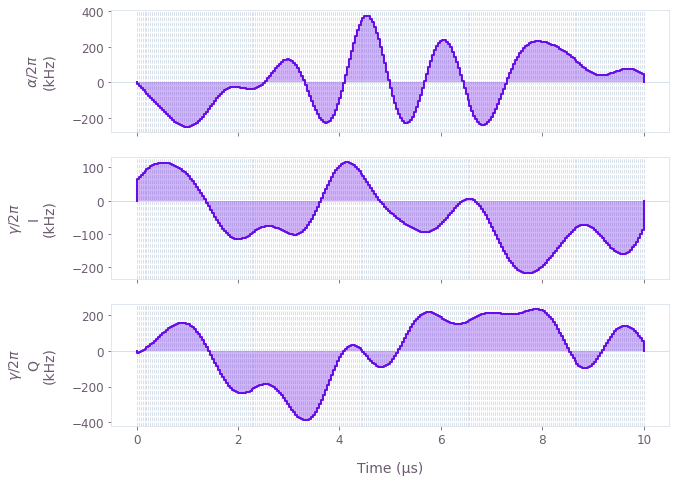

In [5]:
qv.plot_controls(
    {
        "$\\alpha$": optimization_result["output"]["alpha"],
        "$\\gamma$": optimization_result["output"]["gamma"],
    },
    polar=False,
)